In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))
sys.path.append(os.path.abspath("./mergeplg/src/"))

import pycomlink as pycml 
import poligrain as plg

# OpenMRG analysis
OPEN FILES

In [4]:
dataset = 'OpenMRG'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')     
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")          
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc").R_acc                              

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'radar'})  
ds_rad['add_p_idw']=xr.open_dataset(adj_path+dataset+'_add_p_idw.nc').add_p_idw
ds_rad['add_p_ok']=xr.open_dataset(adj_path+dataset+'_add_p_ok.nc').add_p_ok
ds_rad['add_b_ok']=xr.open_dataset(adj_path+dataset+'_add_b_ok.nc').add_b_ok
ds_rad['mul_p_idw']=xr.open_dataset(adj_path+dataset+'_mul_p_idw.nc').mul_p_idw
ds_rad['mul_p_ok']=xr.open_dataset(adj_path+dataset+'_mul_p_ok.nc').mul_p_ok
ds_rad['mul_b_ok']=xr.open_dataset(adj_path+dataset+'_mul_b_ok.nc').mul_b_ok
ds_rad['ked_p']=xr.open_dataset(adj_path+dataset+'_ked_p.nc').ked_p
ds_rad['ked_b']=xr.open_dataset(adj_path+dataset+'_ked_b.nc').ked_b

fields = ['radar', 'add_p_idw', 'add_p_ok', 
          'add_b_ok', 'ked_p', 'ked_b',
          'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

COMPARE RADAR AND RAIN GAUGES

In [5]:
# RAINFALL FIELDS AT THE RAIN GAUGES
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

In [6]:
# COMPUTE METRICS
threshold = 0.2

for field in fields:
        if field == 'radar':
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenMRG'
            metric['method'] = field
            result = metric
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenMRG'
            metric['method'] = field
            result = pd.concat([result, metric])

result.to_csv('metrics_OpenMRG.csv')

In [7]:
result

,ref_thresh,est_thresh,pearson_correlation_coefficient,coefficient_of_variation,root_mean_square_error,mean_absolute_error,percent_bias,reference_mean_rainfall,estimate_mean_rainfall,false_positive_mean_rainfall,false_negative_mean_rainfall,N_all,N_nan,N_nan_ref,N_nan_est,dataset,method
0,0.2,0.2,0.552351,1.274615,1.440088,0.835733,-18.814609,1.117711,0.907418,0.536958,1.256923,24277,0,0,0,OpenMRG,radar
0,0.2,0.2,0.682600,1.030957,1.305720,0.701064,-10.177743,1.260386,1.132107,0.511212,1.637255,24277,0,0,0,OpenMRG,add_p_idw
0,0.2,0.2,0.696003,1.010541,1.266565,0.675495,-10.312691,1.246878,1.118291,0.498852,1.634000,24277,0,0,0,OpenMRG,add_p_ok
0,0.2,0.2,0.696606,1.009246,1.266235,0.674293,-10.388008,1.248041,1.118394,0.498355,1.628571,24277,0,0,0,OpenMRG,add_b_ok
0,0.2,0.2,0.686943,1.018363,1.290163,0.683296,-11.278192,1.259200,1.117185,0.498329,1.728916,24277,0,0,0,OpenMRG,ked_p
0,0.2,0.2,0.687618,1.016449,1.289670,0.682588,-11.336716,1.260980,1.118026,0.498958,1.723600,24277,0,0,0,OpenMRG,ked_b
0,0.2,0.2,0.677492,1.066751,1.317976,0.701177,-6.682407,1.233088,1.150688,0.502706,1.660731,24277,0,0,0,OpenMRG,mul_p_idw
0,0.2,0.2,0.691845,1.042440,1.282964,0.681952,-6.202346,1.228558,1.152359,0.492225,1.657212,24277,0,0,0,OpenMRG,mul_p_ok
0,0.2,0.2,0.692403,1.041250,1.282181,0.680866,-6.321689,1.229123,1.151421,0.491115,1.645714,24277,0,0,0,OpenMRG,mul_b_ok


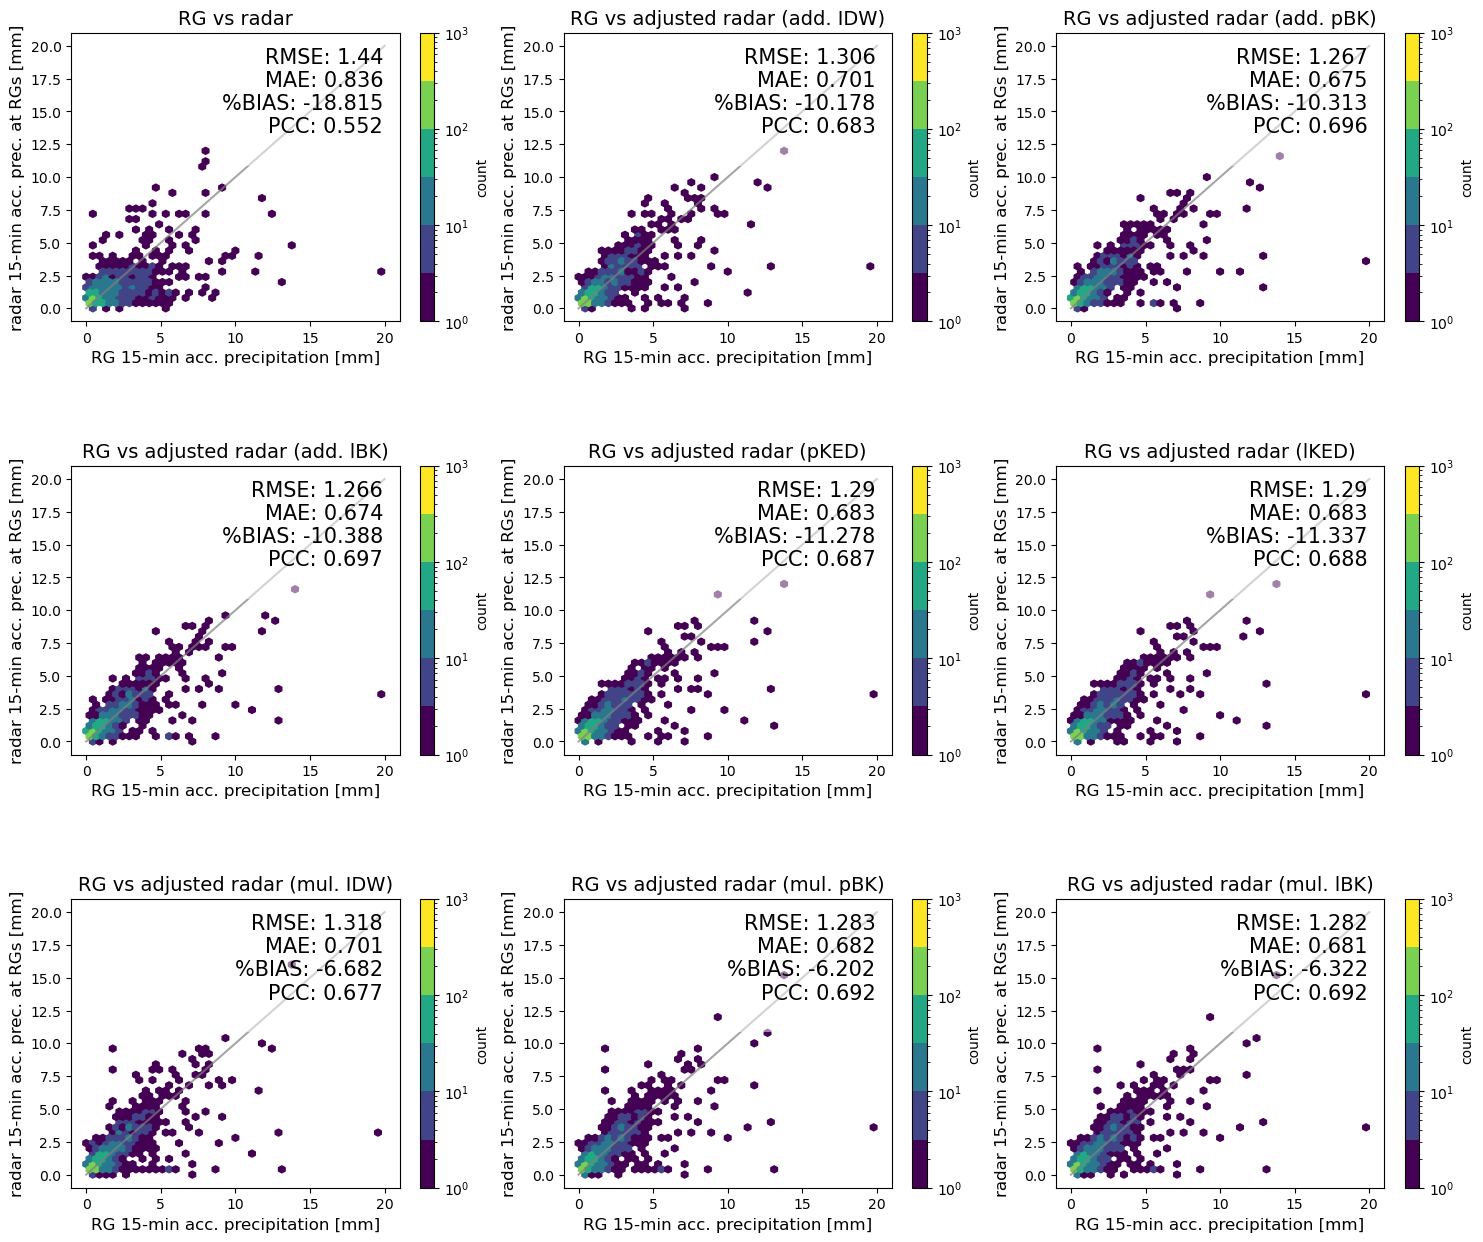

In [8]:
titles = ['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)',
          'RG vs adjusted radar (add. lBK)', 'RG vs adjusted radar (pKED)', 'RG vs adjusted radar (lKED)',
          'RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']

fig, ax = plt.subplots(3, 3, figsize=(18, 15)) 
fax = ax.flatten()
for i in range(len(fax)):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i]].values.flatten(),
            ref_thresh=0.2,
            est_thresh=0.2,
            ax=fax[i],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i]].values.flatten(),
            ref_thresh=0.2,
            est_thresh=0.2)])

        fax[i].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=fax[i].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        fax[i].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        fax[i].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        fax[i].set_title(titles[i], fontsize=14)

plt.subplots_adjust(hspace=0.5)

INTENSITY ANALYSIS

In [9]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,2.5, '[0.2,2.5['], [2.5, 10, '[2.5,10['], [10, 50, '[10,50['], [50, 1000, '>= 50']])
threshold = 0.2

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= float(item[0]))&(ds_gauges.rainfall_amount < float(item[1])), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

result.to_csv('intensity_analysis_OpenMRG.csv')

c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\Bas

## OpenRainER analysis
OPEN FILES

In [10]:
dataset = 'OpenRainER'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/covi_2024_OpenRainER/AWS_rainfall.nc')        
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")       
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc").R_acc             

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'radar'})  
ds_rad['add_p_idw']=xr.open_dataset(adj_path+dataset+'_add_p_idw.nc').add_p_idw
ds_rad['add_p_ok']=xr.open_dataset(adj_path+dataset+'_add_p_ok.nc').add_p_ok
ds_rad['add_b_ok']=xr.open_dataset(adj_path+dataset+'_add_b_ok.nc').add_b_ok
ds_rad['mul_p_idw']=xr.open_dataset(adj_path+dataset+'_mul_p_idw.nc').mul_p_idw
ds_rad['mul_p_ok']=xr.open_dataset(adj_path+dataset+'_mul_p_ok.nc').mul_p_ok
ds_rad['mul_b_ok']=xr.open_dataset(adj_path+dataset+'_mul_b_ok.nc').mul_b_ok
ds_rad['ked_p']=xr.open_dataset(adj_path+dataset+'_ked_p.nc').ked_p
ds_rad['ked_b']=xr.open_dataset(adj_path+dataset+'_ked_b.nc').ked_b

fields = ['radar', 'add_p_idw', 'add_p_ok', 
          'add_b_ok', 'ked_p', 'ked_b',
          'mul_p_idw', 'mul_p_ok', 'mul_b_ok']

In [11]:
# RAINFALL FIELDS AT THE RAIN GAUGES
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

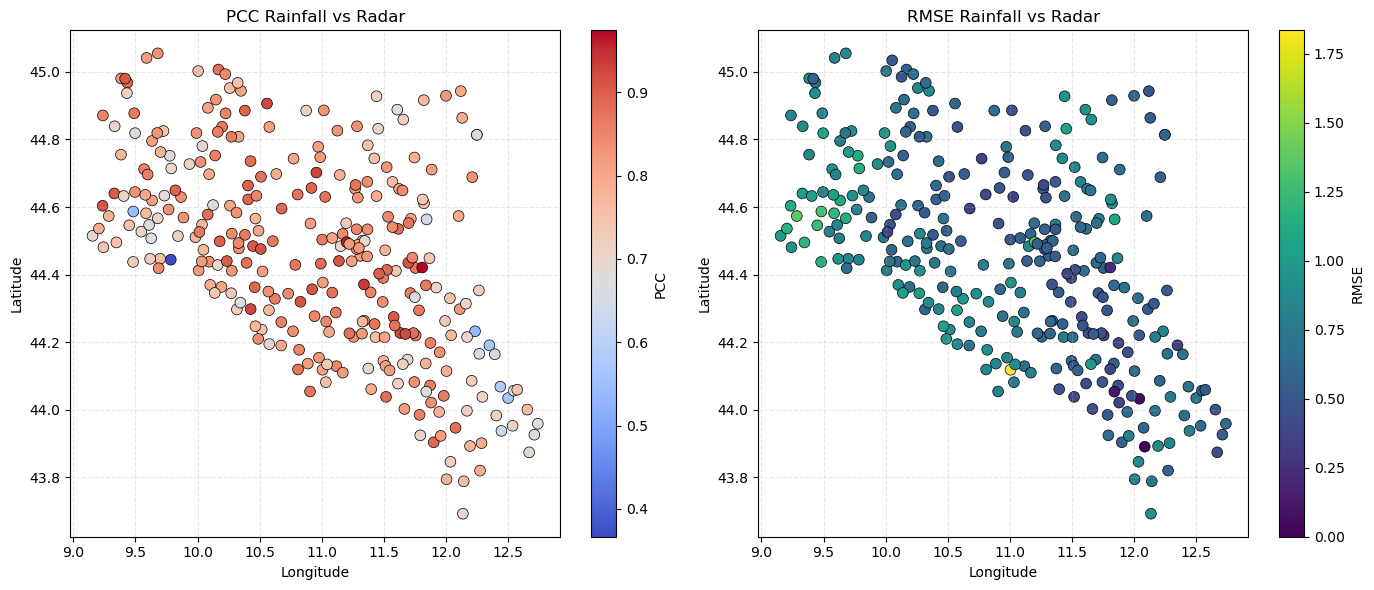

In [12]:
rmse = np.sqrt(
    ((ds_gauges.rainfall_amount - ds_gauges.radar) ** 2).mean(dim="time")
)
pcc = xr.corr(ds_gauges["rainfall_amount"], ds_gauges["radar"], dim="time")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot PCC ---
sc1 = axes[0].scatter(
    pcc.lon,
    pcc.lat,
    c=pcc,
    s=60,
    cmap="coolwarm",
    edgecolors="k",
    linewidth=0.5,
)

axes[0].set_title("PCC Rainfall vs Radar")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(True, linestyle="--", alpha=0.3)
plt.colorbar(sc1, ax=axes[0], label="PCC")


# --- Plot RMSE ---
sc2 = axes[1].scatter(
    rmse.lon,
    rmse.lat,
    c=rmse,
    s=60,
    cmap="viridis",
    edgecolors="k",
    linewidth=0.5,
)

axes[1].set_title("RMSE Rainfall vs Radar")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(True, linestyle="--", alpha=0.3)
plt.colorbar(sc2, ax=axes[1], label="RMSE")

plt.tight_layout()
plt.show()

In [13]:
# COMPUTE METRICS
threshold = 0.2

for field in fields:
        if field == 'radar':
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenRainER'
            metric['method'] = field
            result = metric
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenRainER'
            metric['method'] = field
            result = pd.concat([result, metric])

result.to_csv('metrics_OpenRainER.csv')

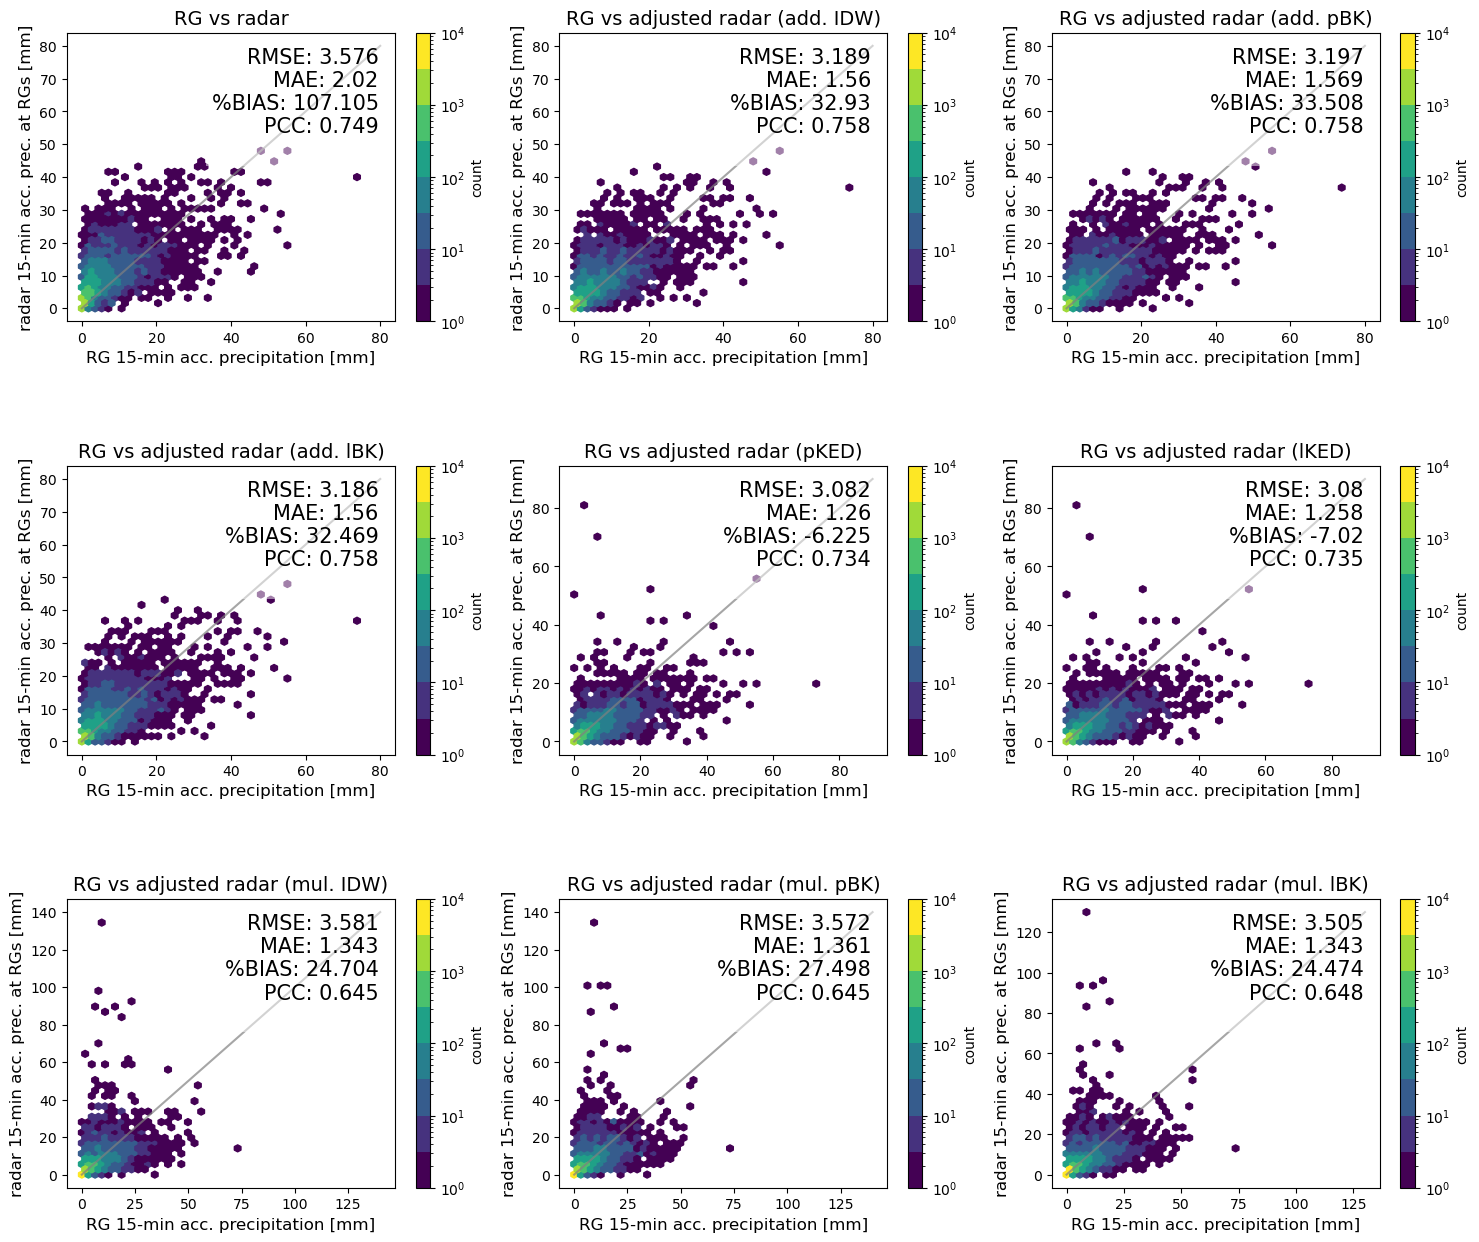

In [14]:
titles = ['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)',
          'RG vs adjusted radar (add. lBK)', 'RG vs adjusted radar (pKED)', 'RG vs adjusted radar (lKED)',
          'RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']

fig, ax = plt.subplots(3, 3, figsize=(18, 15)) 
fax = ax.flatten()
for i in range(len(fax)):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i]].values.flatten(),
            ref_thresh=0.2,
            est_thresh=0.2,
            ax=fax[i],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i]].values.flatten(),
            ref_thresh=0.2,
            est_thresh=0.2)])

        fax[i].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=fax[i].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        fax[i].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        fax[i].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        fax[i].set_title(titles[i], fontsize=14)

plt.subplots_adjust(hspace=0.5)

DISTANCE ANALYSIS

In [15]:
distances = np.arange(2000, 32000, 2000) # [m]
threshold = 0.2

start = 0
for max_distance in distances:
    closest_neigbors = plg.spatial.get_closest_points_to_line(
        ds_cmls, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=len(ds_gauges.id.values)
    )

    closest_rgs = closest_neigbors.neighbor_id.values.flatten()
    ds_closegauges = ds_gauges.sel(id=np.unique(closest_rgs[closest_rgs!= None]))

    for field in fields:

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_closegauges.rainfall_amount.values.flatten(),
            estimate=ds_closegauges[field].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold,
        )])
        metric['distance'] = [max_distance]
        metric['field'] = [field]
        metric['n_gauges'] = [len(ds_closegauges.id.values)]

        if start == 0:
            result_metric = metric
            start += 1
        else:
            result_metric = pd.concat([result_metric, metric])

result_metric.to_csv('metrics_distance.csv')

C:\Users\Utente\AppData\Local\Temp\ipykernel_5764\2317479980.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues_r", len(distances))
C:\Users\Utente\AppData\Local\Temp\ipykernel_5764\2317479980.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(rmse_groups, labels=labels, showfliers=False, patch_artist=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_5764\2317479980.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(pcc_groups, labels=labels, showfliers=False, patch_artist=True)


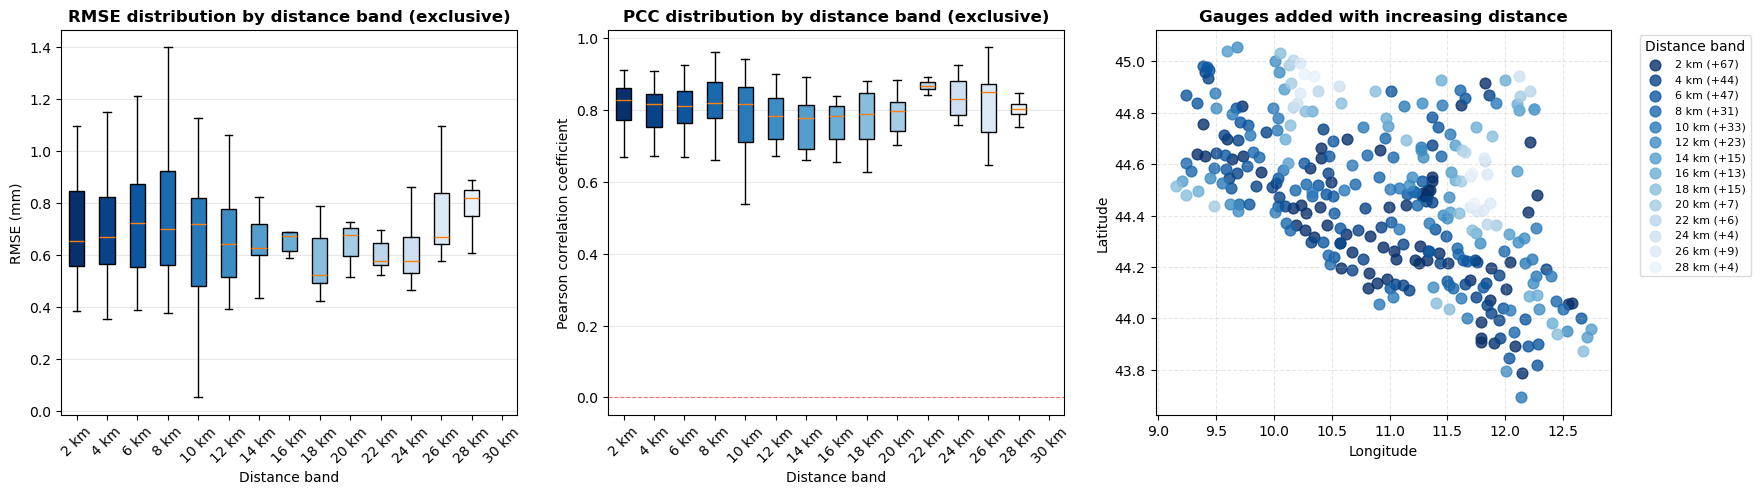

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.cm as cm

# --- PARAMETERS ---
distances = np.arange(2000, 32000, 2000)  # in meters
cmap = cm.get_cmap("Blues_r", len(distances))

# --- CALCULATE RMSE AND PCC ---
rmse = np.sqrt(((ds_gauges.rainfall_amount - ds_gauges.radar)**2).mean(dim="time"))
pcc = xr.corr(ds_gauges["rainfall_amount"], ds_gauges["radar"], dim="time")

# --- GROUP GAUGES BY DISTANCE BANDS (EXCLUSIVE) ---
groups = {}
all_seen_ids = set()

for i, max_distance in enumerate(distances):
    try:
        closest_neighbors = plg.spatial.get_closest_points_to_line(
            ds_cmls,
            ds_gauges.rainfall_amount,
            max_distance=max_distance,
            n_closest=len(ds_gauges.id.values)
        )
        
        closest_rgs = closest_neighbors.neighbor_id.values.flatten()
        # Remove None values and get unique IDs
        valid_ids = [id_val for id_val in closest_rgs if id_val is not None]
        current_ids = set(valid_ids)
        
        # Get only NEW gauges not seen in previous distance bands
        new_ids = current_ids - all_seen_ids
        
        dist_km = int(max_distance / 1000)
        groups[dist_km] = list(new_ids)
        
        # Update the set of all seen IDs
        all_seen_ids.update(new_ids)
        
    except Exception as e:
        print(f"Error at distance {max_distance}m: {e}")
        dist_km = int(max_distance / 1000)
        groups[dist_km] = []

# --- PREPARE DATA FOR BOXPLOTS ---
labels = [f"{km} km" for km in sorted(groups.keys())]
rmse_groups = []
pcc_groups = []

for km in sorted(groups.keys()):
    gauge_ids = groups[km]
    if len(gauge_ids) > 0:
        # Get RMSE and PCC values for gauges in this distance group
        rmse_vals = rmse.sel(id=gauge_ids).values
        pcc_vals = pcc.sel(id=gauge_ids).values
        
        # Remove NaN values
        rmse_vals = rmse_vals[~np.isnan(rmse_vals)]
        pcc_vals = pcc_vals[~np.isnan(pcc_vals)]
        
        rmse_groups.append(rmse_vals if len(rmse_vals) > 0 else [])
        pcc_groups.append(pcc_vals if len(pcc_vals) > 0 else [])
    else:
        rmse_groups.append([])
        pcc_groups.append([])

# --- PLOT BOX PLOTS AND SPATIAL MAP ---
fig = plt.figure(figsize=(20, 5))

# Create grid for subplots: 2 boxplots + 1 map
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# RMSE subplot
bp1 = ax1.boxplot(rmse_groups, labels=labels, showfliers=False, patch_artist=True)
ax1.set_title("RMSE distribution by distance band (exclusive)", fontsize=12, fontweight='bold')
ax1.set_ylabel("RMSE (mm)", fontsize=10)
ax1.set_xlabel("Distance band", fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Color the boxes
for patch, i in zip(bp1['boxes'], range(len(bp1['boxes']))):
    patch.set_facecolor(cmap(i))

# PCC subplot
bp2 = ax2.boxplot(pcc_groups, labels=labels, showfliers=False, patch_artist=True)
ax2.set_title("PCC distribution by distance band (exclusive)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Pearson correlation coefficient", fontsize=10)
ax2.set_xlabel("Distance band", fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=0.8)

# Color the boxes
for patch, i in zip(bp2['boxes'], range(len(bp2['boxes']))):
    patch.set_facecolor(cmap(i))

# Spatial map subplot
all_seen_ids_map = set()

for i, max_distance in enumerate(distances):
    try:
        closest_neighbors = plg.spatial.get_closest_points_to_line(
            ds_cmls,
            ds_gauges.rainfall_amount,
            max_distance=max_distance,
            n_closest=len(ds_gauges.id.values)
        )
        
        closest_rgs = closest_neighbors.neighbor_id.values.flatten()
        valid_ids = [id_val for id_val in closest_rgs if id_val is not None]
        current_ids = set(valid_ids)
        
        # Get only NEW gauges
        new_ids = current_ids - all_seen_ids_map
        
        if new_ids:
            ds_new = ds_gauges.sel(id=list(new_ids))
            color = cmap(i)
            
            ax3.scatter(
                ds_new.lon,
                ds_new.lat,
                alpha=0.8,
                s=60,
                color=color,
                label=f"{max_distance/1000:.0f} km (+{len(new_ids)})"
            )
        
        all_seen_ids_map.update(new_ids)
        
    except Exception as e:
        print(f"Error plotting distance {max_distance}m: {e}")

ax3.set_xlabel("Longitude", fontsize=10)
ax3.set_ylabel("Latitude", fontsize=10)
ax3.set_title("Gauges added with increasing distance", fontsize=12, fontweight='bold')
ax3.grid(True, linestyle="--", alpha=0.3)
ax3.legend(title="Distance band", framealpha=0.7, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')

INTENSITY ANALYSIS

In [17]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,2.5, '[0.2,2.5['], [2.5, 10, '[2.5,10['], [10, 50, '[10,50['], [50, 1000, '>= 50']])
threshold = 0.2

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= float(item[0]))&(ds_gauges.rainfall_amount < float(item[1])), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

result.to_csv('intensity_analysis_OpenRainER.csv')

c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\Documents\radar_adjustment_intercomparison\poligrain\src\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\L